# NFL Rush Success

People love to claim, that rushing the ball in the NFL is important.  If only team X had a good rushing game they would have a great offense.

So lets dig into that and try to answer that question.

For this analysis we will be using play by play from the last 5 NFL seasons (2014 to 2018).  This data is turned into CSV by the nflscrapR project https://github.com/maksimhorowitz/nflscrapR.

In [1]:
# pull in and configure the tools we are going to use
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
pd.options.display.max_columns = None

### Pull in all our data
We are using precompiled data from https://github.com/ryurko/nflscrapR-data/

### Game Data

In [2]:
games_df = pd.concat([
    pd.read_csv('https://github.com/ryurko/nflscrapR-data/raw/master/games_data/regular_season/reg_games_2018.csv'),
    pd.read_csv('https://github.com/ryurko/nflscrapR-data/raw/master/games_data/regular_season/reg_games_2017.csv'),
    pd.read_csv('https://github.com/ryurko/nflscrapR-data/raw/master/games_data/regular_season/reg_games_2016.csv'),
    pd.read_csv('https://github.com/ryurko/nflscrapR-data/raw/master/games_data/regular_season/reg_games_2015.csv'),
    pd.read_csv('https://github.com/ryurko/nflscrapR-data/raw/master/games_data/regular_season/reg_games_2014.csv'),
])


In [3]:
def team_rename(name):
    if name == "JAC":
        return "JAX"
    if name == "SD":
        return "LAC"
    if name == "STL":
        return "LA"
    return name

### Team name changes must be dealt with, we will use the new name in the old years
 * 2014,2015 JAC => JAX for 2016,2017,2018
 * 2014,2015,2016 SD => LAC for 2017,2018
 * 2014,2015 STL => LA for 2016,2017,2018

In [4]:
games_df['home_team'] = games_df['home_team'].apply(team_rename)
games_df['away_team'] = games_df['away_team'].apply(team_rename)

def game_won(row):
    if row['home_score'] > row['away_score']:
        return row['home_team']
    elif row['home_score'] < row['away_score']:
        return row['away_team']
    else:
        return "TIE"

games_df['winner'] = games_df.apply(game_won, axis=1)
games_df.head()

,type,game_id,home_team,away_team,week,season,state_of_game,game_url,home_score,away_score,winner
0,reg,2018090600,PHI,ATL,1,2018,POST,http://www.nfl.com/liveupdate/game-center/2018...,18,12,PHI
1,reg,2018090900,BAL,BUF,1,2018,POST,http://www.nfl.com/liveupdate/game-center/2018...,47,3,BAL
2,reg,2018090907,NYG,JAX,1,2018,POST,http://www.nfl.com/liveupdate/game-center/2018...,15,20,JAX
3,reg,2018090906,NO,TB,1,2018,POST,http://www.nfl.com/liveupdate/game-center/2018...,40,48,TB
4,reg,2018090905,NE,HOU,1,2018,POST,http://www.nfl.com/liveupdate/game-center/2018...,27,20,NE


### For the play by play data, we are going to remove the non run/pass plays, (qb spikes etc)

In [5]:
years = []
for x in range(2014, 2019):
    current = pd.read_csv('https://github.com/ryurko/nflscrapR-data/raw/master/play_by_play_data/regular_season/reg_pbp_%d.csv' % x)
    current['season'] = x
    years.append(current)

pbp_raw_df = pd.concat(years, sort=False)

/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,203,204,205,231,232,233,238,240,241) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (42,166,167,174,175,178,179,182,183,188,189,203,204,205,231,232,233,238,240,241) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (167,168,169,170,175,176,179,180,183,184,189,190,191,192,195,196,199,200,204,205,206,227,228,232,233,234,239,241,242) have mixed types. Specify dtype option on import or set low_memory=False.
  interact

In [6]:
plays_per_season = pbp_raw_df.groupby(['season']).count()[['play_id']]
plays_per_season.columns = ['Plays per season']
plays_per_season


,Plays per season
season,
2014,45502
2015,46129
2016,45736
2017,45244
2018,45143


In [7]:


pbp_raw_df["posteam"] = pbp_raw_df["posteam"].apply(team_rename)

In [8]:
pbp_raw_df['play_type'].unique()

array(['kickoff', 'run', 'no_play', 'pass', 'punt', 'field_goal',
       'extra_point', nan, 'qb_kneel', 'qb_spike'], dtype=object)

In [9]:
condition = (pbp_raw_df['play_type'] == "run") | (pbp_raw_df['play_type'] == "pass")
pbp_df = pbp_raw_df[condition]

pbp_df.describe()

,play_id,game_id,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,quarter_end,drive,sp,qtr,down,goal_to_go,ydstogo,ydsnet,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,air_yards,yards_after_catch,kick_distance,home_timeouts_remaining,away_timeouts_remaining,timeout,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,home_wp_post,away_wp_post,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,lateral_sack_player_id,lateral_sack_player_name,assist_tackle_3_player_id,assist_tackle_3_player_name,assist_tackle_3_team,assist_tackle_4_player_id,assist_tackle_4_player_name,assist_tackle_4_team,fumble_recovery_1_yards,fumble_recovery_2_yards,return_yards,penalty_yards,replay_or_challenge,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,season,touchback
count,160900.000000,1.609000e+05,160900.000000,160900.000000,160882.000000,160878.000000,160900.0,160900.000000,160900.000000,160900.000000,160483.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.0,160900.0,160900.000000,88897.000000,56568.000000,0.0,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.0,160900.000000,160900.000000,160500.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,88869.000000,88691.000000,160858.000000,160772.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,1.609000e+05,1.609000e+05,1.609000e+05,1.609000e+05,160232.000000,160232.000000,160232.000000,160900.000000,160900.000000,160900.000000,160900.000000,88788.000000,88660.000000,160777.000000,160721.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.0,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.000000,160900.0,160900.0,160900.0,160900.0,160900.0,160900.0,160900.0,160900.0,160900.0,1609

## Lets get some general ideas about run/pass ratios in the nfl

In [10]:
play_type = pbp_df.groupby(['play_type']).count()[['play_id']]
play_type.columns = ['Count']
play_type.loc['Total'] = play_type['Count'].sum()
play_type["%"] = play_type['Count'].apply(lambda x: x/play_type.loc['Total'])
play_type

,Count,%
play_type,,
pass,95232,0.591871
run,65668,0.408129
Total,160900,1.000000


In [11]:
play_type_year = pbp_df.groupby(['play_type', 'season']).count()[['play_id']]
play_type_year

play_id
play_type season         
pass      2014      18981
          2015      19427
          2016      19350
          2017      18577
          2018      18897
run       2014      13325
          2015      13092
          2016      12971
          2017      13373
          2018      12907

In [12]:
play_type_year = pd.pivot_table(pbp_df, values='play_id', index=['season'], columns=['play_type'], aggfunc=["count"], margins=True)
play_type_year.insert(0, '% pass',(play_type_year['count']['pass'] / play_type_year['count']['All'] * 100))
play_type_year.insert(1, '% run',(play_type_year['count']['run'] / play_type_year['count']['All'] * 100))
play_type_year

% pass      % run  count               
play_type                         pass    run     All
season                                               
2014       58.753792  41.246208  18981  13325   32306
2015       59.740459  40.259541  19427  13092   32519
2016       59.868197  40.131803  19350  12971   32321
2017       58.143975  41.856025  18577  13373   31950
2018       59.417054  40.582946  18897  12907   31804
All        59.187073  40.812927  95232  65668  160900

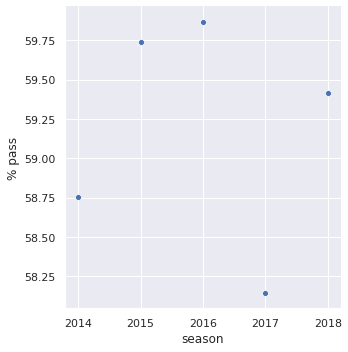

In [13]:
play_type_year_plot = play_type_year.reset_index()
play_type_year_plot.columns = play_type_year_plot.columns.droplevel(level=1)
play_type_year_plot = play_type_year_plot[(play_type_year_plot['season'] != 'All')]
sns.relplot(x="season", y="% pass", data=play_type_year_plot)



### Some analysis
The league average run/pass split over the last 5 years has been 60/40 plus or minus 2 %.
There doesn't seem to be any trends here.

In [44]:
import numpy as np

play_type_team_year = pd.pivot_table(pbp_df, values='play_id', index=['posteam'], columns=['season','play_type'], aggfunc=["count"], margins=True).reset_index()
play_type_team_year.columns = play_type_team_year.columns.droplevel(level=0)
play_type_team_year.columns = play_type_team_year.columns.droplevel(level=0)
play_type_team_year.columns = ['team','2014 pass','2014 run', '2015 pass', '2015 run','2016 pass', '2016 run', '2017 pass', '2017 run', '2018 pass', '2018 run', 'team total']
rush_by_team_year = pd.DataFrame()
rush_by_team_year['team'] = play_type_team_year['team']
for season in range(2014,2019):
    new_col = season
    run_col = '%d run' % season
    pass_col = '%d pass' % season
    rush_by_team_year[new_col] = np.float64(play_type_team_year[run_col] / (play_type_team_year[run_col] + play_type_team_year[pass_col]) * 100)
    
rush_by_team_year = rush_by_team_year[rush_by_team_year['team'] != 'All'].transpose()
rush_by_team_year.columns = rush_by_team_year.loc['team']
rush_by_team_year = rush_by_team_year.drop(index='team')
rush_by_team_year






team,ARI,ATL,BAL,BUF,CAR,CHI,CIN,CLE,DAL,DEN,DET,GB,HOU,IND,JAX,KC,LA,LAC,MIA,MIN,NE,NO,NYG,NYJ,OAK,PHI,PIT,SEA,SF,TB,TEN,WAS
2014,39.1437,36.0352,43.3433,39.0828,44.3495,34.4411,47.7092,47,49.499,40.595,37.0225,42.4057,51.0557,36.4641,36.3083,43.1414,40.7173,39.5604,37.6585,41.658,39.9431,36.7593,40.9683,48.0806,34.0491,41.2985,38.7344,50.6,45.8753,37.9978,38.2908,39.799
2015,42.2,38.3743,35.4089,49.4012,48.9423,45.4902,45.935,36.1969,41.7973,38.5277,33.7917,40.5172,40.9955,36.6375,34.5581,44.9522,45.9669,35.4662,34.5078,48.125,35.3741,35.3105,38.0038,40.9991,35.9799,39.633,36.8368,47.384,39.5616,44.3888,37.9132,41.5
2016,36.3045,41.54,33.4901,48.4608,42.9119,39.0805,42.1002,35.5465,48.5915,39.5418,35.2577,35.3755,42.2053,38.5222,37.0335,40.4541,38.6316,39.0656,44.5061,36.8844,44.8209,36.2718,38.1143,41.5493,40.3304,40.1869,38.7795,38.8945,45.749,41.4611,46.5327,36.9478
2017,37.9079,43.4021,43.0368,47.5806,46.8719,45.1404,39.7124,38.1618,47.49,41.9567,36.4851,38.391,43.6399,45.102,48.03,40.7179,44.3648,40.4618,35.947,46.332,41.0646,43.5005,37.7065,42.7979,38.2572,43.3048,40.5248,40.1423,38.2325,37.5486,44.8852,40.4124
2018,38.8143,34.1948,47.3968,45.992,40.5433,45.2357,37.9978,39.4477,42.2465,38.3848,39.0918,32.2517,45.0732,36.9025,41.1234,38.2892,42.3631,41.1953,41.7149,34.9398,43.619,45.5005,35.6345,41.8239,38.5246,38.0721,31.7354,52.5888,41.5911,36.3289,47.9526,42.5732


## Its interesting how much variance there is in pass % by team year to year

It also seems to cancel itself out

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffba13254a8>,
      dtype=object)

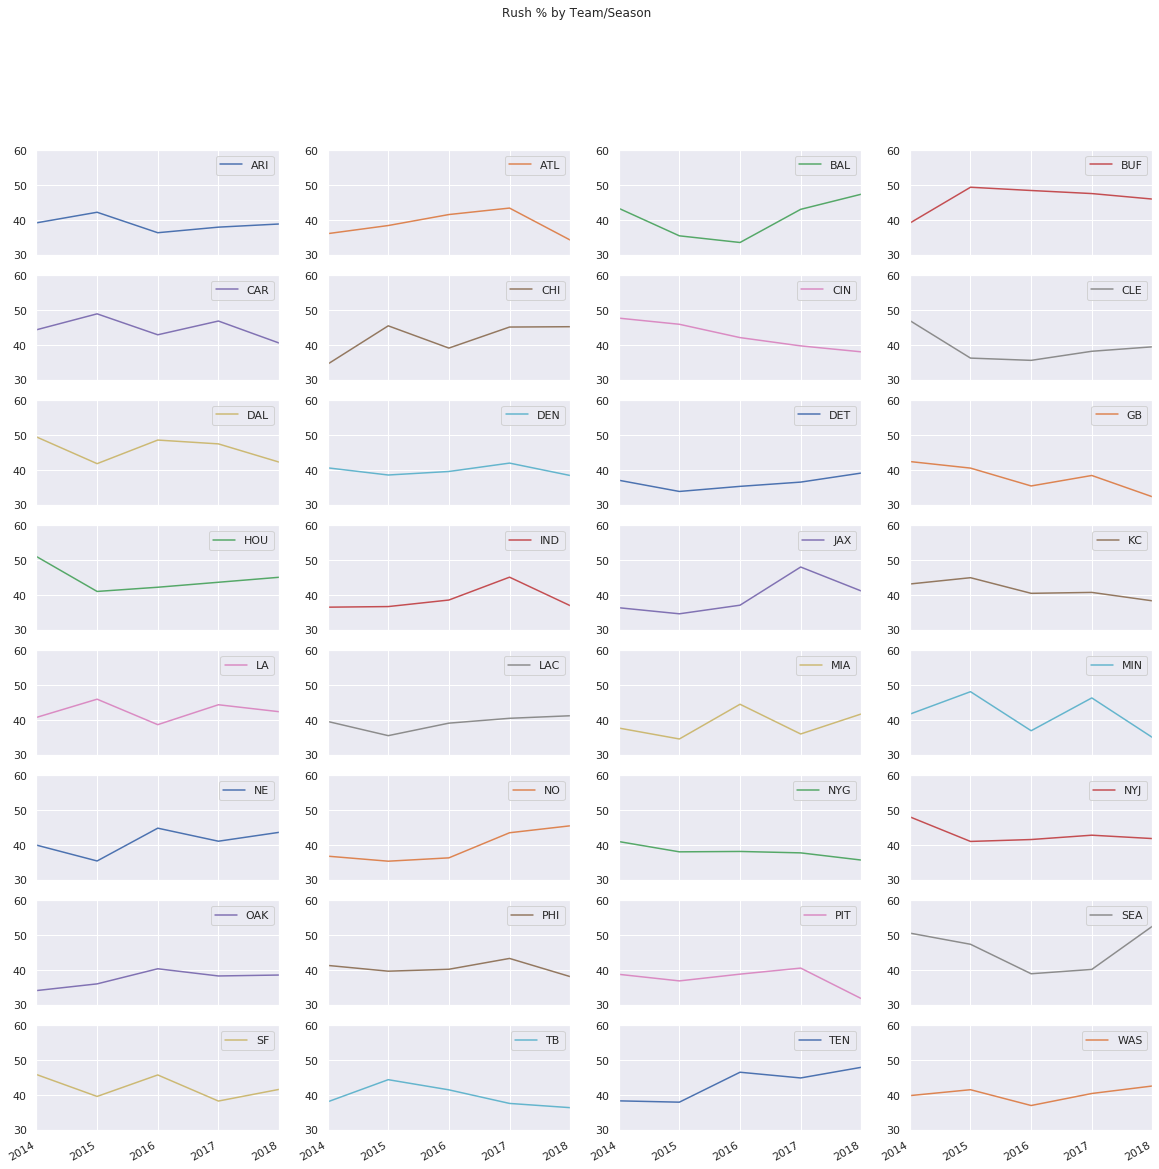

In [15]:
rush_by_team_year_plot = rush_by_team_year.plot(subplots=True, layout=(8,4), figsize=(20,20), ylim=(30,60), title="Rush % by Team/Season")
rush_by_team_year_plot

# Lets see if rush % correlates with anything
 * Number of wins
 * Number of points scored

In [45]:
wins_by_team_season = games_df.groupby(['winner','season']).count()[['game_id']]

# ok got some things to fix, had, some ties, so lets just remove those
# also 0 wins ends up as NaN so lets make that 0 (thanks Clevland)
wins_by_team_season = wins_by_team_season.unstack().drop(index='TIE').fillna(value=0)
wins_by_team_season.columns = wins_by_team_season.columns.droplevel(level=0)
wins_by_team_season = wins_by_team_season.transpose()
wins_by_team_season


winner,ARI,ATL,BAL,BUF,CAR,CHI,CIN,CLE,DAL,DEN,DET,GB,HOU,IND,JAX,KC,LA,LAC,MIA,MIN,NE,NO,NYG,NYJ,OAK,PHI,PIT,SEA,SF,TB,TEN,WAS
season,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014,11.0,6.0,10.0,9.0,7.0,5.0,10.0,7.0,12.0,12.0,11.0,12.0,9.0,11.0,3.0,9.0,6.0,9.0,8.0,7.0,12.0,7.0,6.0,4.0,3.0,10.0,11.0,12.0,8.0,2.0,2.0,4.0
2015,13.0,8.0,5.0,8.0,15.0,6.0,12.0,3.0,4.0,12.0,7.0,10.0,9.0,8.0,5.0,11.0,7.0,4.0,6.0,11.0,12.0,7.0,6.0,10.0,7.0,7.0,10.0,10.0,5.0,6.0,3.0,9.0
2016,7.0,11.0,8.0,7.0,6.0,3.0,6.0,1.0,13.0,9.0,9.0,10.0,9.0,8.0,3.0,12.0,4.0,5.0,10.0,8.0,14.0,7.0,11.0,5.0,12.0,7.0,11.0,10.0,2.0,9.0,9.0,8.0
2017,8.0,10.0,9.0,9.0,11.0,5.0,7.0,0.0,9.0,5.0,9.0,7.0,4.0,4.0,10.0,10.0,11.0,9.0,6.0,13.0,13.0,11.0,3.0,5.0,6.0,13.0,13.0,9.0,6.0,5.0,9.0,7.0
2018,3.0,7.0,10.0,6.0,7.0,12.0,6.0,7.0,10.0,6.0,6.0,6.0,11.0,10.0,5.0,12.0,13.0,12.0,7.0,8.0,11.0,13.0,5.0,4.0,4.0,9.0,9.0,10.0,4.0,5.0,9.0,7.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb9fa56be0>,
      dtype=object)

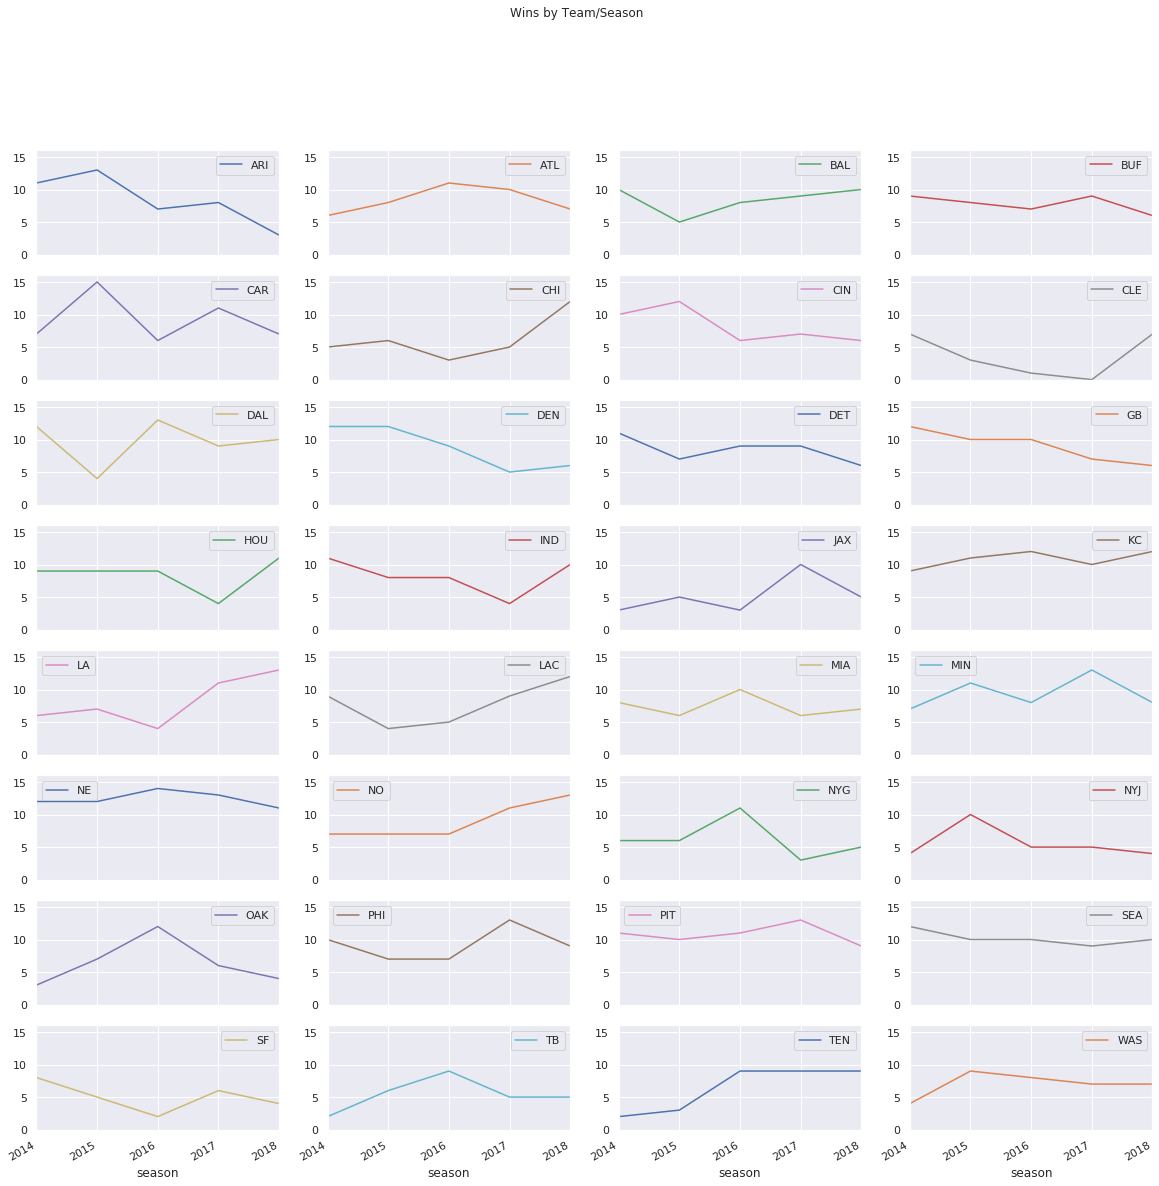

In [17]:
wins_by_team_season.plot(subplots=True, layout=(8,4), figsize=(20,20), ylim=(0, 16), title="Wins by Team/Season")

In [90]:
wins_unstacked = pd.DataFrame(wins_by_team_season.unstack(), columns=["Wins"])
wins_unstacked.index.names = ['team','season']
rush_unstacked = pd.DataFrame(rush_by_team_year.unstack(), columns=["Rush %"])
rush_unstacked.index.names = ['team','season']
wins_rush = wins_unstacked.merge(rush_unstacked, left_index=True, right_index=True)
wins_rush['Rush %'] = np.float64(wins_rush['Rush %'])

#per team correlation
wins_rush['Correlation'] = 0
for key in wins_rush.index.values:
    team = key[0]
    wins_rush.loc[[team], ['Correlation']] = wins_rush.loc[team].corr()['Rush %'].loc['Wins']
    
wins_rush_plot = wins_rush.reset_index()

# Higher rushing % is correlated with winning
Its not the strongest correlation, but there is something there.  Winning teams are rushing more.

In [61]:
wins_rush.corr()

,Wins,Rush %
Wins,1.000000,0.345659
Rush %,0.345659,1.000000


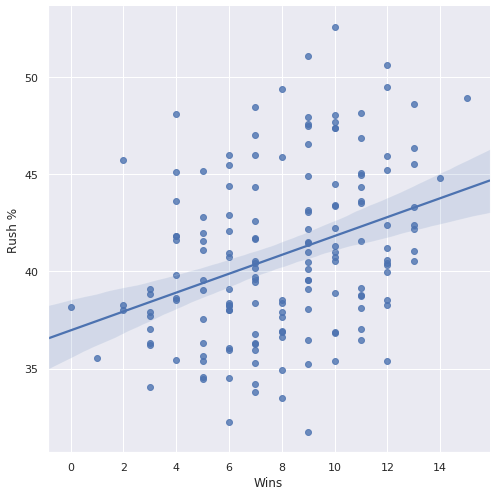

In [51]:
sns.lmplot(x="Wins", y="Rush %", data=wins_rush_plot,height=7)

# Team by team breakdown
This is pretty dicey due to the small # of data points at this point.  But it seems pretty clear, that some teams are rushing more when winning and some aren't.

Some of the more interesting things are, that GB wins when running more. KC wins when running less, and around 7 different teams it just doesn't matter.

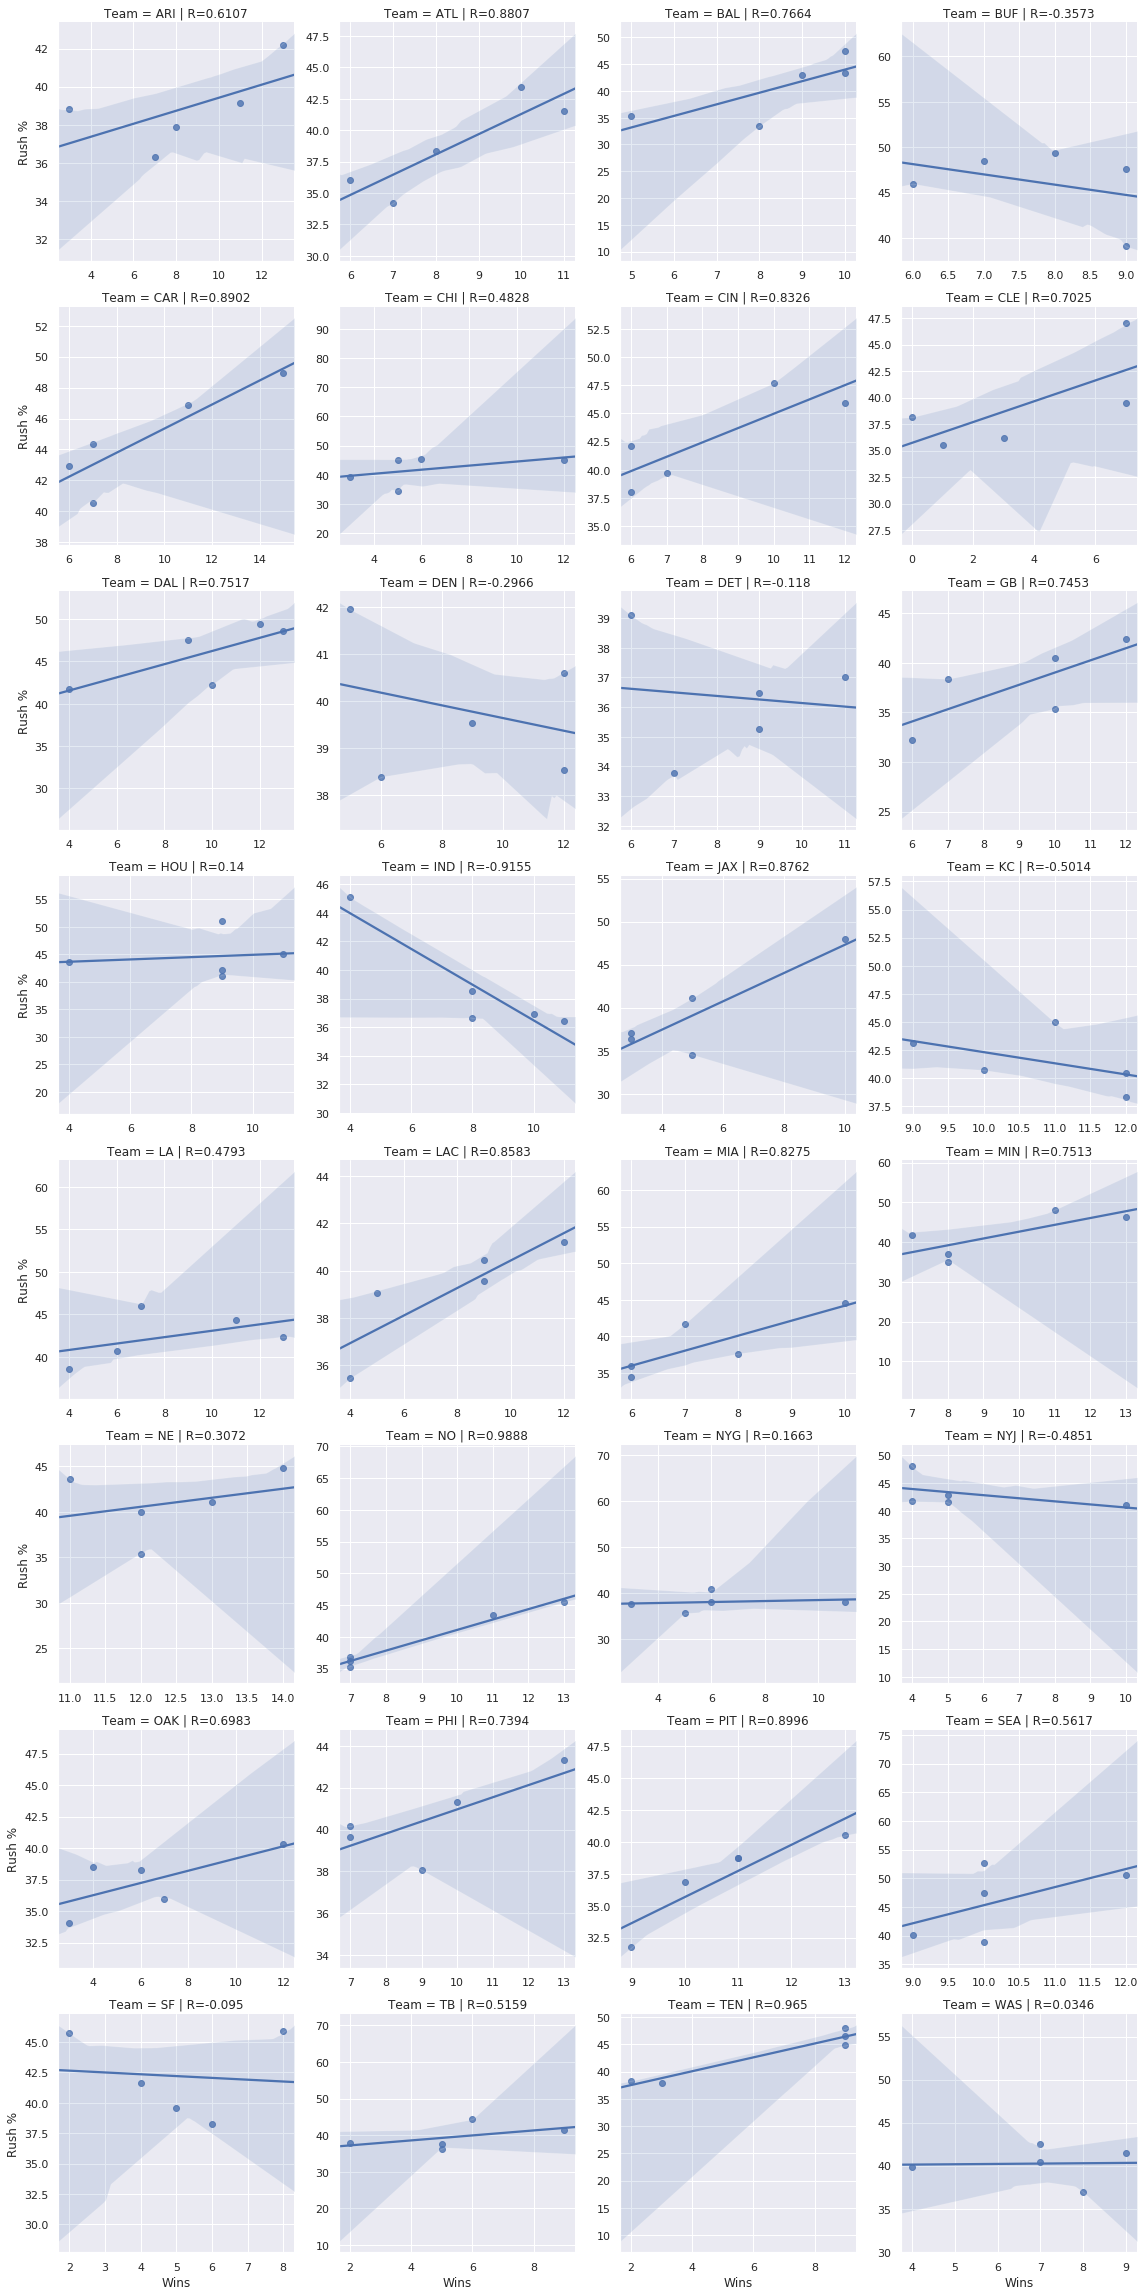

In [103]:
def build_label(row):
    return "%s | R=%s" % (row['team'], np.round(row['Correlation'], 4))

wins_rush_plot["Team"] = wins_rush_plot.apply(build_label , axis=1)

sns.lmplot(x="Wins", y="Rush %", col="Team", data=wins_rush_plot, col_wrap=4, height=4, sharex=False, sharey=False)


# One explation your often hear, for why winning teams run more is that they are running out the clock

Lets first look at running with at least an 8 point lead at any point in the game.

In [ ]:
pbp_with_an_8_point_lead = pbp_df[(pbp_df['score_differential'] > 7)]
pbp_with_an_8_point_lead.groupby(['posteam','season']).count()[['game_id']]